In [ ]:
import tweepy
import webbrowser
from tweepy import Stream
from tweepy.streaming import StreamListener
from tweepy import Cursor
from tweepy import API
import pandas as pd
import numpy as np
import re
from textblob import Word, TextBlob
import nltk
import matplotlib.pyplot as plt

# API_key = zQk7acKmTbFnJqlkA6p0C7VXJ
# API_secret_Key = zpDNW5CQH52V6Bb2BKCjKDVogi8iDeND9S6x23fWUtympUxr0c
# Bearer_Token = AAAAAAAAAAAAAAAAAAAAAM%2BCSQEAAAAAQjlVDeu7C7%2BGLoOslqEpR7MawHg%3DEteDy5j1NaGD2JcZK7FMo6iN7hmNyLIA1ZMmHOvEF4VPnnq6ls

In [ ]:
# We shall be analysing tweets with respect to presidential debate

consumer_key = '5iM7WsOnBxmuLwg7N4yFgRGgv'
consumer_secret ='AprvWHmF9hXWdbEYPMUE3vq4dnJHmRrx7GCJZbi3g4IWPrTFZ3'
callback_url= 'oob'
auth= tweepy.OAuthHandler(consumer_key,consumer_secret,callback_url) # Authenticate our User
redirect_url = auth.get_authorization_url() # Get URL to direct user
# print(redirect_url)
webbrowser.open(redirect_url)
user_pint_input = input ("What's the pin value? ")
user_pint_input
auth.get_access_token(user_pint_input)
api= tweepy.API(auth, wait_on_rate_limit=True)
me = api.me()

In [ ]:
# Setting up tweeter handler

hashtag = '#covid-19'
query = tweepy.Cursor(api.search, q=hashtag,lang='en').items(300)  # The search method will help us search
# print(dir(query)) 
tweets = [ {'Tweets':tweet.text, 'Timestamp':tweet.created_at} for tweet in query]
print(tweets)

In [ ]:
# Import tweets into a data frame
# convert dictionary to list
tweets = list(tweets) 
df = pd.DataFrame(tweets, columns=['Tweets','Timestamp'])
print(df)

In [ ]:

# Cleaning tweets

def clean_text(raw_text):
    raw_text = re.sub(r'@[A-Za-z0-9]+','',raw_text)
    raw_text = re.sub(r'#','',raw_text)
    raw_text = re.sub(r'RT[\s]+','',raw_text)
    raw_text = re.sub(r'https?:\/\/\S+','',raw_text)
    raw_text = re.sub(r':','',raw_text)
    raw_text = re.sub(r'_','',raw_text)
    raw_text = re.sub(r'\n\n','',raw_text)
    raw_text = re.sub(r'--&','',raw_text)
    raw_text = re.sub(r'\n','',raw_text)
    return raw_text

df['Tweets'] = df['Tweets'].apply(clean_text)

print(df)
#print(df.shape)

In [ ]:
# Remove emorjis
def removeEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

df['Tweets'] = df['Tweets'].apply(removeEmojify)

print(df)

In [ ]:

covid_refs = ['COVID','covid','COVID-19','covid-19','COVID_19','covid_19','COVID19','covid19','COVID 19','covid 19']

def identify_subject(tweet,refs):
    flag = 0
    for ref in refs:
        if tweet.find(ref) != -1:
            flag = 1
    return flag

df['Covid'] = df['Tweets'].apply(lambda x: identify_subject(x,covid_refs) )

print(df)

In [ ]:
# Subjectivity and the polarity

# How much a piece of text is based on emotion or how objective or subjective it is ranging from 0 to 1
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# How positive or negative something is ranging from -1 to 1
def getPolarity(text): 
    return TextBlob(text).sentiment.polarity

df['Subjectivity'] = df['Tweets'].apply(getSubjectivity)
df['Polarity'] = df['Tweets'].apply(getPolarity)

print(df)

In [ ]:
df[df['Covid']==1][['Covid','Polarity','Subjectivity']].groupby('Covid').agg([np.mean,np.max,np.min,np.median])

In [ ]:
# Visualize

covid_19 = df[df['Covid']==1][['Timestamp','Polarity']]
covid_19 = covid_19.sort_values(by='Timestamp', ascending=True)
covid_19['Ma Polarity'] = covid_19.rolling(10, min_periods=3).mean()

print(covid_19)

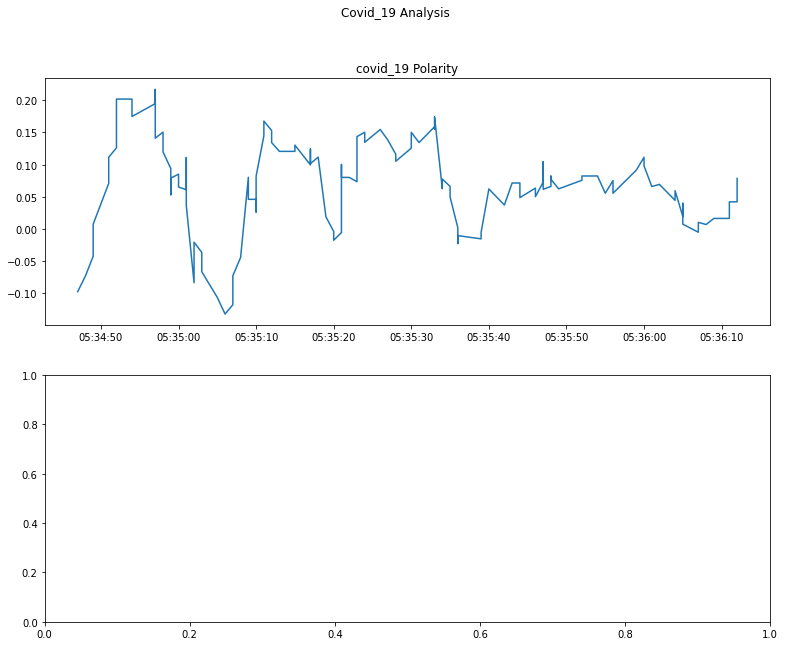

In [27]:

fig, axes = plt.subplots(2,figsize=(13, 10))

axes[0].plot(covid_19['Timestamp'], covid_19['Ma Polarity'])
axes[0].set_title("\n".join(["covid_19 Polarity"]))


fig.suptitle("\n".join(["Covid_19 Analysis"]), y=0.98)
plt.show()

In [ ]:

def getAnalysys(score):
        if score<0:
            return 'Negative'
        else:
            return 'Positive'

df['Analysis'] = df['Polarity'].apply(getAnalysys)

print(df)

In [ ]:

 # print all positive tweets
print('*****Positive Tweets*****')
j = 1
sortedDF = df.sort_values(by=['Polarity'])
for i in range(0,sortedDF.shape[0]):
    if (sortedDF['Analysis'][i]=='Positive'):
            print(str(j) + ')'+ sortedDF['Tweets'][i])
            #print()
            j +=1


# print all negative tweets
print('*****Negative Tweets*****')
j = 1
sortedDF = df.sort_values(by=['Polarity'], ascending='False')
for i in range(0,sortedDF.shape[0]):
     if (sortedDF['Analysis'][i]=='Negative'):
            print(str(j) + ')'+ sortedDF['Tweets'][i])
            #print()
            j +=1
            

In [ ]:

 # Get the percentage of positive tweets
ptweets = df[df.Analysis == 'Positive']
ptweets = ptweets['Tweets']
percent = round((ptweets.shape[0] / df.shape[0]) * 100, 1)
print(percent)


# Get the percentage of negative tweets
ntweets = df[df.Analysis == 'Negative']
ntweets = ntweets['Tweets']
percent = round((ntweets.shape[0] / df.shape[0]) * 100, 1)
print(percent)